In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Gibbs Sampling (alternating conditioning sampling)

Suppose the parameter vector $\theta$ has been divided into $d$ components or subvectors, $\theta = (\theta_1, ...., \theta_d)$. Each iterationn of the Gibbs sampler cycles through the subvectors of $\theta$, drawing each subset conditional on the value of all the others. There are thus $d$ steps in each iteration $t$. At each iteration $t$, an ordering of the $d$ subvectors of $\theta$ is chosen and, in turn, each $\theta_j^t$ is sampled from the conditional distribution given all the other components of $\theta$:

$$p(\theta_j | \theta_{-j}^{t-1}, y), $$

where $\theta_{-j}^{t-1}$ represents all of the components of $\theta$ except for $\theta_j$, at their current values. 

**Example. Bivariate normal distribution**
Consider a single observation $(y_1, y_2)$ from a bivariate normally distributed population with unknown mean $(\theta_1, \theta_2)$ and known covariance matrix $\left(\begin{array}{cc} 1 & \rho \\ \rho & 1 \end{array}\right)$. With a uniform prior distribution on $\theta$, the posterior distribution is:

$$ \left(\begin{array}{cc} \theta_1 \\ \theta_2 \end{array}\right) | y \sim N(\left(\begin{array}{cc} y_1 \\ y_2 \end{array}\right), \left(\begin{array}{cc} 1 & \rho \\ \rho & 1 \end{array}\right))$$

Then the conditional posterior distributions would be:

$$ \theta_1 | \theta_2, y \sim N(y_1 + \rho(\theta_2 - y_2), 1 - \rho^2) $$
$$ \theta_2 | \theta_1, y \sim N(y_2 + \rho(\theta_1 - y_1 ), 1 - \rho^2) $$

Let's try an example where $\rho$ = 0.8, $(y_1, y_2) = (0, 0)$, and the starting points for four markers are $(\pm2.5, \pm2.5)$.

In [2]:
rho = 0.8
y = np.array([0, 0])
cov = np.array([[1, rho], [rho, 1]])

#normally, this would be how we define theta values
#but here, we are going to use the four makerks below
#theta1 = np.random.multivariate_normal(y, cov)
#theta2 = np.random.multivariate_normal(y, cov)

top_right = (2.5, 2.5)
bottom_right = (2.5, -2.5)
bottom_left = (-2.5, -2.5)
top_left = (-2.5, 2.5)

markers = [top_right, bottom_right, bottom_left, top_left]

In [3]:
def gibbs_sampling(theta, y, rho, iterations):
    theta1 = theta[0]
    theta2 = theta[1]
    
    y1 = y[0]
    y2 = y[1]
    updates = []
    updates.append([theta1, theta2])
    
    for i in range(iterations):
        stdev = 1 - rho**2
        
        if i%2==0:
            mean = y1 + rho * (theta2 - y2)
            theta1 = np.random.normal(mean, stdev)
        else:
            mean = y2 + rho * (theta1 - y1)
            theta2 = np.random.normal(mean, stdev)

        updates.append([theta1, theta2])
    
    return updates

In [4]:
iters = 1000
tr = gibbs_sampling(top_right, y, rho, iters)
br = gibbs_sampling(bottom_right, y, rho, iters)
bl = gibbs_sampling(bottom_left, y, rho, iters)
tl = gibbs_sampling(top_left, y, rho, iters)

update_list = [tr, br, bl, tl]

In [5]:
def plot_gibbs_sampler(starting_points, updates, savefig):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    #plot first 10 iterations
    for updates in update_list:
        x = [update[0] for update in updates[:10]]
        y = [update[1] for update in updates[:10]]
        ax[0].plot(x, y, 'k-', linewidth=0.5)
        
    #plot first 500 iterations
    for updates in update_list:
        x = [update[0] for update in updates[:500]]
        y = [update[1] for update in updates[:500]]
        ax[1].plot(x, y, 'k-', linewidth=0.5)

    #plot second half of sequences as points
    for updates in update_list:
        half_length = len(updates) // 2
        x = [update[0] for update in updates[half_length:]]
        y = [update[1] for update in updates[half_length:]]
        ax[2].plot(x, y, color='k', marker='o', ms=0.5, alpha=0.2)

    markers = [(-2.5, -2.5), (-2.5, 2.5), (2.5, -2.5), (2.5, 2.5)]
    
    for point in starting_points:
        ax[0].plot(point[0], point[1], 'ks')
        ax[1].plot(point[0], point[1], color='k', marker='s')
    
    for i in range(0, 3):
        ax[i].set_xlim(-4, 4)
        ax[i].set_ylim(-4, 4)
    
    ax[0].set_xlabel('10 iterations')
    ax[1].set_xlabel('500 iterations')
    ax[2].set_xlabel('Second half of iterations')
    
    if savefig:
        plt.savefig('gibbs_sampling.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

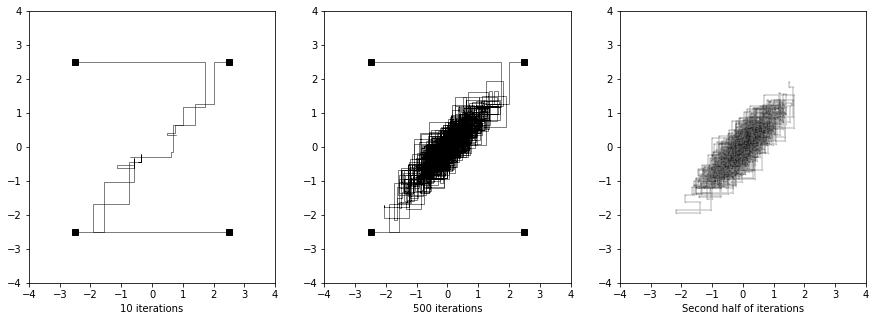

In [6]:
plot_gibbs_sampler(markers, update_list, False)

### Metropolis-Hastings algorithm

I read a lot of material on the Metropolis-Hastings algorithm, but I think this [StackExchange post](https://stats.stackexchange.com/questions/56737/understanding-mcmc-and-the-metropolis-hastings-algorithm) describes it the best.

For each iteration $t$ in $T$:
1. Pick an initial random state $x_0$ 
2. Generate a candidate (also called proposal) $x^*$ from $Q(.|x_0)$
3. Calculate the ratio $\alpha = f(x^*)/f(x_0)$
4. Accept $x^*$ as a realisation of $f$ with probability $\alpha$
5. Use $x^*$ as the new starting value (or initial state).

$Q(.|.)$ is called a transition model, and is supposed to be proportional to the overal model shape that we are trying to achieve. So since we are modelling a Gaussian process, our transition model should be a Normal distribution.

In [7]:
# target probability
def p(x):
    sigma = np.array([[1, 0.8], [0.8, 1]])
    return stats.multivariate_normal.pdf(x, cov=sigma)

# proposal distribution
def q(x_prime, x):
    return stats.multivariate_normal.pdf(x_prime, mean=x)

In [8]:
#based on this implementation: http://khalibartan.github.io/MCMC-Metropolis-Hastings-Algorithm/
#look here: http://shubhanshu.com/blog/metropolis-hastings-primer.html
def metropolis_hastings(x, iterations):
    np.random.seed(42)

    #stack quantities of interest
    samples = np.zeros((iterations, len(x)))
    likelihood = np.zeros((iterations, 1))
    
    for t in range(iterations):
        #first iteration: starting point, then x is updated
        samples[t] = x
        ##pick candidate proposal distribution for update
        x_prime = np.random.multivariate_normal(mean=x, cov=np.eye(2), size=1).flatten()
        
        #calculate acceptance/rejection probability
        ratio = (p(x_prime) * q(x, x_prime)) / (p(x) * q(x_prime, x))
        acceptance_prob = min(1, ratio)
        
        #accept new position with probability u
        u = np.random.uniform(0, 1)
        
        if acceptance_prob >= u:
            x = x_prime
        else:
            x = x
        
        #save likelihood once we have accepted/rejected x
        #likelihood[t] = np.sum(np.log(p(x)))
        likelihood[t] = np.sum(p(x))

    return likelihood, samples

In [9]:
T = 5000
like_tr, samples_tr = metropolis_hastings(top_right, T)
like_br, samples_br = metropolis_hastings(bottom_right, T)
like_bl, samples_bl = metropolis_hastings(bottom_left, T)
like_tl, samples_tl = metropolis_hastings(top_left, T)

In [10]:
def plot_mh_samples(starting_point, samples, burnin):
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    #plot starting point as square
    ax[0].plot(starting_point[0], starting_point[1], 'bs', ms=10, label='Starting point')
    
    #plot first hundred samples
    ax[0].scatter(samples[:,0], samples[:,1], alpha=0.8, s=1, color='k', label='MCMC samples')
    ax[0].plot(samples[0:100, 0], samples[0:100, 1], color='orangered', linestyle='--', label='First 100 samples')
    
    #plot last hundred samples
    ax[0].plot(samples[-100:, 0], samples[-100:, 1], color='cyan', linestyle='--', alpha=0.8, label='Last 100 samples')

    #plot true minimum
    ax[0].plot(0, 0, color='yellow', marker='*', ms=20, label='True minimum')
    
    plotmax = 3.5
    ax[0].set_xlim(-plotmax, plotmax)
    ax[0].set_ylim(-plotmax, plotmax)
    
    #plot chains
    ax[1].plot(samples[:, 0], label='x0', color='tab:blue')
    ax[1].axhline(samples[:, 0].mean(), color='red', linestyle='--', label='Mean')
    ax[1].fill_between(range(len(samples[:burnin, 0])), -plotmax, plotmax, color='red', alpha=0.3, label='Burn in')
    
    ax[2].plot(samples[:, 1], label='x1', color='tab:blue')
    ax[2].axhline(samples[:, 1].mean(), color='red', linestyle='--', label='Mean')
    ax[2].fill_between(range(len(samples[:burnin, 1])), -plotmax, plotmax, color='red', alpha=0.3, label='Burn in')
    
    ax[0].legend()
    ax[1].legend(loc='upper right')
    ax[2].legend(loc='upper right')
    plt.show()

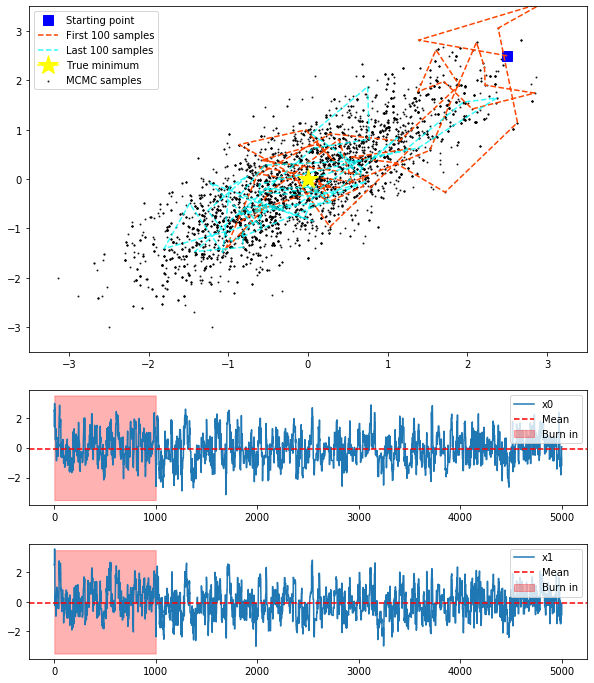

In [11]:
plot_mh_samples(top_right, samples_tr, burnin=1000)

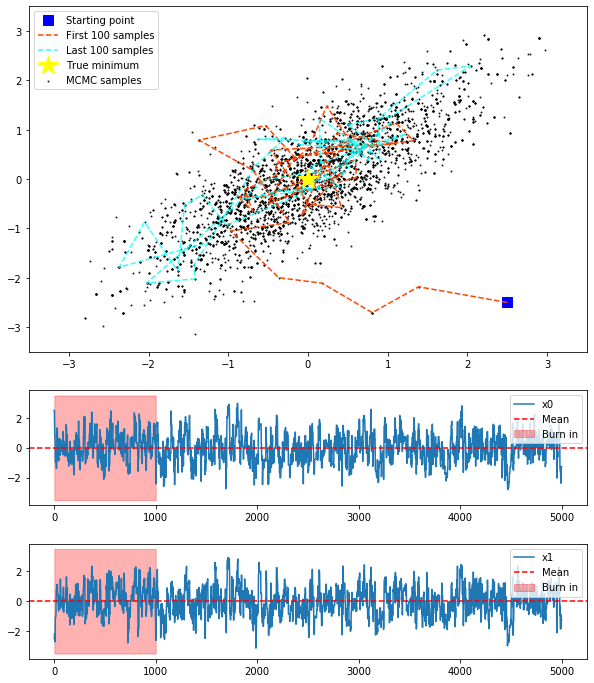

In [12]:
plot_mh_samples(bottom_right, samples_br, burnin=1000)

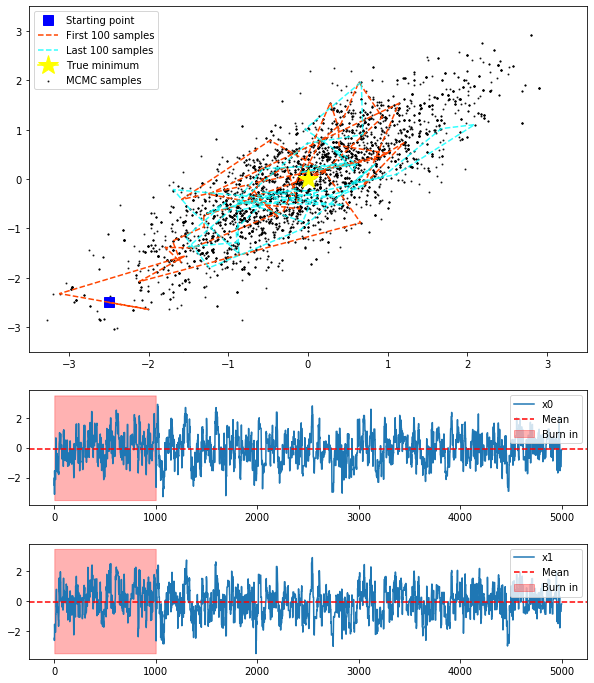

In [13]:
plot_mh_samples(bottom_left, samples_bl, burnin=1000)

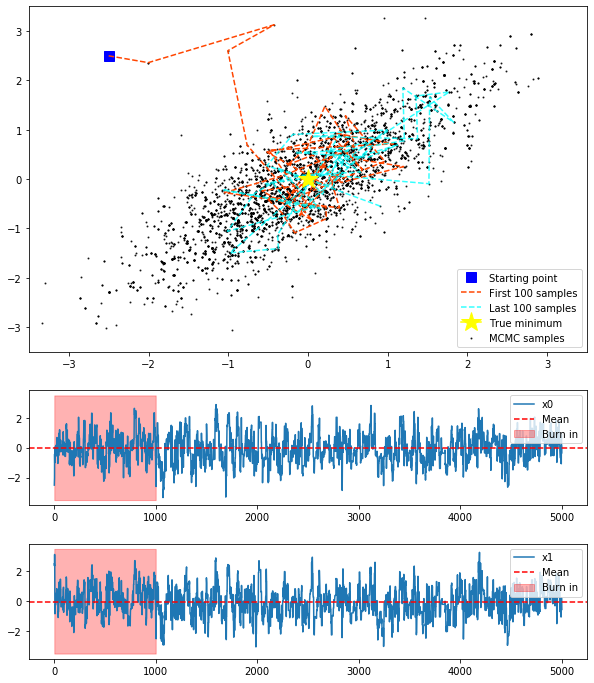

In [14]:
plot_mh_samples(top_left, samples_tl, burnin=1000)

## Burn in

MCMC methods can take a while to find a local or global minimum, so we would like to be able to remove the first `n` samples in a chain.

In [15]:
def burn(samples, burnin):
    """
    Returns a series of samples after a given starting position.
    
    Parameters:
        samples: time series of points in a MCMC chain
        burnin: desired staring position
    
    Returns:
        new_samples: shortened version of samples array
    """
    return samples[burnin:, :]

In [16]:
burnedin_tr = burn(samples_tr, 1000)
burnedlike_tr = burn(like_tr, 1000)

#test that burn in method takes off the requested amount of samples
print('Shape of samples array before burn in: {}'.format(samples_tr.shape))
print('Shape of samples array after burn in: {}'.format(burnedin_tr.shape))

Shape of samples array before burn in: (5000, 2)
Shape of samples array after burn in: (4000, 2)


## Calculating $n_{eff}$

Next, we need to implement some method of 
- assessing how a given chain is converging to a global minimum
- assessing the number of effective samples that we have, $n_{eff}$ in a given chain.

For the $n_{eff}$ calculation, we can look to Equations 11.5-11.8 in *Bayesian Data Analysis*:

$$ \lim_{n \to \infty} mn \text{var}(\bar{\psi}..) = (1 + 2 \sum_{t=1}^T \infty) \text{var}(\psi | y)$$

$$ n_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \rho_t} $$

$$ V_t = \frac{1}{m(n-t)} \sum_{j=1}^m \sum_{i=t+1}^n (\psi_{i,j} - \psi_{i-t,j})^2 $$


$$ \hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho_t}} $$

- $m$ represents the number of chains
- $n$ represents the number of simulation draws, or samples
- $\rho_t$ is the autocorrelation of the sequence $\psi$ at time lag $t$
- $V_t$ is the variogram at each time lag $t$

When we do this, we can plot a histogram of every $n_{eff}$ points from one of our chains, and we would hope that these points match our true target distribution. For example: If we have 100 points, and $n_{eff}$ is 20, then we take every 5th point from our chain and plot it as a histogram. If our data came from a Normal distribution, then we would hope that our histogram of efficient points matches that.

First, let's compute the variogram. We can use the top right samples as an example. Here, after burn in, we have 4000 samples and two chains, one for each of $x_1$, $x_2$. This means that we will need to iterate over $n=4000$ time steps and $m=2$ chains.

In [17]:
print(burnedin_tr.shape)
print(burnedlike_tr.shape)

burnedll_tr = np.log(burnedlike_tr)
print(burnedll_tr.shape)

(4000, 2)
(4000, 1)
(4000, 1)


In [18]:
def autocorrelation(array, t):
    """
    Return the autocorrelation of an array with itself for a given
    time lag. The array should be 1D, so if your array is > 1D you
    will need to select an axis.
    """
    rows = array.shape[0] - 1
    
    if t < 0:
        print('Please enter a positive integer')
        return
    if t > rows:
        print('You have entered a time lag greater than the length of the array')
        return
    elif t==0:
        auto = np.sum(array - array)
    else:
        auto = np.sum((array[t:] - array[:-t])**2)
    
    return auto

In [19]:
def variogram(array, t):
    m = array.shape[1]
    n = array.shape[0]
    divisor = m * (n - t)
    sum_m = 0
    
    for column in range(m):
        auto = autocorrelation(array[:, column], t)
        sum_m += auto
    
    variogram = sum_m / divisor
    return variogram

In [20]:
Vt = [variogram(burnedll_tr, i) for i in range(0, 3999)]

In [21]:
def calculate_vplus(array):
    m = array.shape[1]
    n = array.shape[0]
    
    #B calculation: between-sequence variances
    psi_dot_j = np.sum(array, axis=0) / n #sum over rows
    psi_dot_dot = np.sum(psi_dot_j) / m   #sum over columns
    
    if(m==1): #avoid division by zero error
        B = n * np.sum((psi_dot_j - psi_dot_dot)**2)
    else:
        B = (n / (m - 1)) * np.sum((psi_dot_j - psi_dot_dot)**2)
    
    print('B:', B)
    
    #W calculation: within-sequence variances
    sj2 = np.sum((array - psi_dot_dot)**2, axis=0) / (n - 1)
    W = np.sum(sj2) / m
    print('W: ', W)
    
    #var_plus calculation: marginal posterior variance of the estimand
    var_plus = (((n - 1) * W) + B) / n
    print('V+: ', var_plus)
    
    return B, W, var_plus

In [22]:
#B, W, var_plus = calculate_vplus(burnedin_tr)
B, W, var_plus = calculate_vplus(burnedll_tr)

B: 0.0
W:  0.8012776283823647
V+:  0.8010773089752692


According to the textbook, this quantity *overestimates* the marginal variance assuming that starting distribution is appropriately overdispursed, but *unbiased* under stationarity. This is analagous to the classical variance estimate with cluster sampling.

In [23]:
def calculate_rho(V, vplus):
    #calculate estimate of rho, rho_hat, for every variogram
    rho_full = []
    for i in range(len(V)):
        rho_hat = 1 - Vt[i]/(2*vplus)
        rho_full.append(rho_hat)
    
    #this time with the counter of 2 consecutive negative rho values == break
    flag = 0
    for i in range(len(rho_full)):
        #we are only considering odd integers
        #but since python is 0-indexed, I am going to use even integers
        if(i%2==0):
            condition = np.logical_and(rho_full[i+1] < 0, rho_full[i+2] < 0)
            if(condition==True):
                flag = i
                break

    return flag, rho_full

In [24]:
flag, rho = calculate_rho(Vt, var_plus)

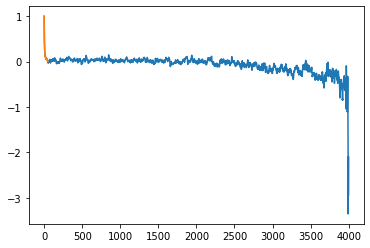

In [25]:
plt.plot(rho)
plt.plot(rho[:flag])
plt.show()

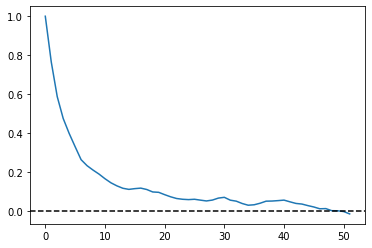

In [26]:
plt.plot(rho[:flag+2])
plt.axhline(y=0.0, color='k', linestyle='--')
plt.show()

In [27]:
def calculate_neffective(rho_full, flag, m, n):
    """
    Calculate the estimated number of effective samples in an MCMC chain
    """
    
    rho_sum = np.sum(rho_full[:flag])
    n_eff = (m * n) / (1 + (2 * rho_sum))
    
    return int(n_eff)

In [28]:
m, n = burnedlike_tr.shape[1], burnedlike_tr.shape[0]
n_eff = calculate_neffective(rho, flag, m, n)
print(n_eff)

265


In [29]:
every_n_tr = int(len(burnedin_tr) / n_eff)

burnedin_tr_subset = burnedin_tr[::every_n_tr, :]

col0 = burnedin_tr_subset[:, 0]
col1 = burnedin_tr_subset[:, 1]

In [30]:
print(every_n_tr)
print(col0.shape)
print(col1.shape)

15
(267,)
(267,)


In [31]:
def pdf(array):
    """
    We know mu and std a priori because we specified it above.
    So mu=0, var=1.
    """
    xmin, xmax = array.min(), array.max()
    x = np.linspace(xmin, xmax, 1000)
    p = stats.norm.pdf(x, 0, 1)
    
    return x, p

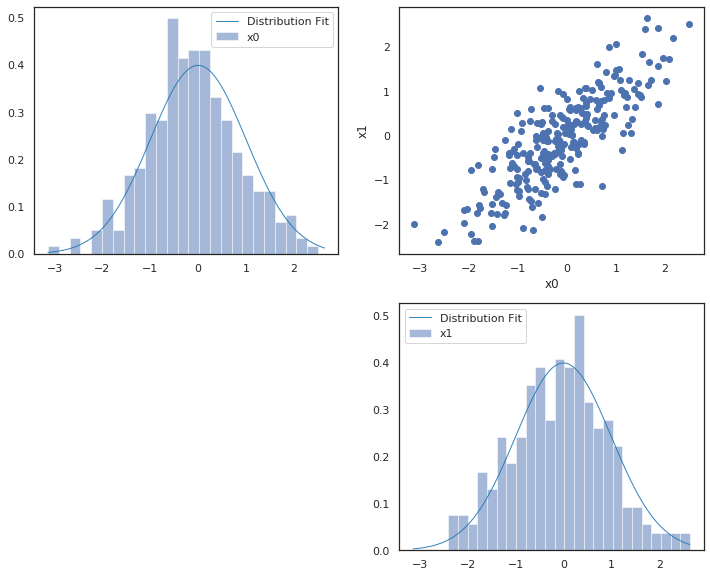

In [32]:
sns.set(style='white')
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

x, p = pdf(burnedin_tr_subset.reshape(-1, 1)[:, 0])

#top left
ax[0, 0].hist(col0, bins=25, density=True, alpha=0.5, label='x0')
ax[0, 0].plot(x, p, 'tab:blue', alpha=0.9, linewidth=1, label='Distribution Fit')
              
#top right
ax[0, 1].scatter(col0, col1)
ax[0, 1].set_xlabel('x0')
ax[0, 1].set_ylabel('x1')

#bottom left
ax[1, 0].set_axis_off()

#bottom right
ax[1, 1].hist(col1, bins=25, density=True, alpha=0.5, label='x1')
ax[1, 1].plot(x, p, 'tab:blue', alpha=0.9, linewidth=1, label='Distribution Fit')

ax[0, 0].legend()
ax[1, 1].legend()
plt.show()

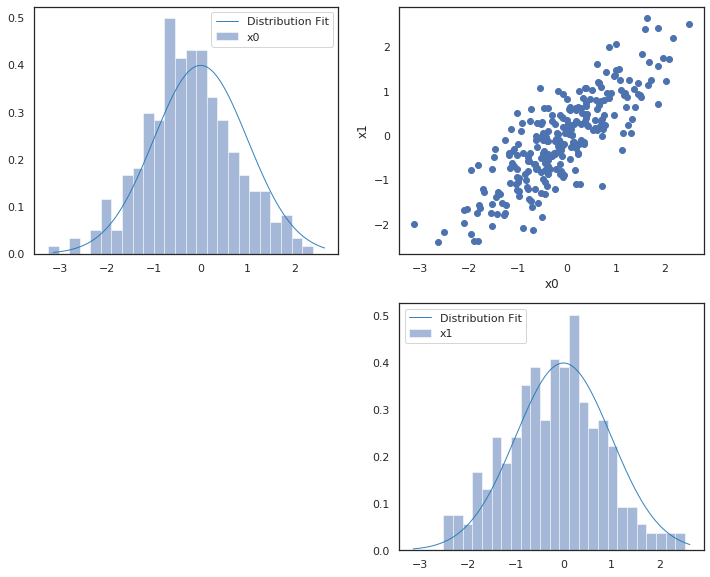

In [33]:
sns.set(style='white')
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

x, p = pdf(burnedin_tr_subset.reshape(-1, 1)[:, 0])

#top left
hist, bins = np.histogram(col0, bins=25, density=True)
ax[0, 0].bar(bins[:-1], hist, width=np.diff(bins), alpha=0.5, label='x0')
ax[0, 0].plot(x, p, 'tab:blue', alpha=0.9, linewidth=1, label='Distribution Fit')

#top right
ax[0, 1].scatter(col0, col1)
ax[0, 1].set_xlabel('x0')
ax[0, 1].set_ylabel('x1')

#bottom left
ax[1, 0].set_axis_off()

#bottom right
hist, bins = np.histogram(col1, bins=25, density=True)
ax[1, 1].bar(bins[:-1], hist, width=np.diff(bins), alpha=0.5, label='x1')
ax[1, 1].plot(x, p, 'tab:blue', alpha=0.9, linewidth=1, label='Distribution Fit')

ax[0, 0].legend()
ax[1, 1].legend()
plt.show()

**Resources**
- Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. Bayesian data analysis, 3rd edition. CRC press, 2020.
- http://khalibartan.github.io/MCMC-Metropolis-Hastings-Algorithm/